# Self-organizing Maps (SOM)

In [7]:
# load python packages
import numpy as np
import pandas as pd
import xarray as xr
import math
import matplotlib as mpl

# load machine learning packages
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing

# minisom package for SOM
!pip install minisom
import minisom
from minisom import MiniSom

from matplotlib.patches import Patch

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
import matplotlib.cbook as cbook

  Using cached MiniSom-2.3.2-py3-none-any.whl


## Global figure settings

In [8]:
# customize figure 
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams["axes.unicode_minus"] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['hatch.linewidth'] = 2.5

In [9]:
# little function
def remove_time_mean(x):
    return x - x.mean(dim='time')

# Importing data from disk

In [10]:
dust_df = pd.read_csv('../saharan_dust_met_vars.csv', index_col='time')

# print out shape of data 
print('Shape of data:', np.shape(dust_df))

# print first 5 rows of data
print(dust_df.head())
feature_names = dust_df.columns

Shape of data: (18466, 10)
                 PM10         T2        rh2         slp       PBLH  RAINC  \
time                                                                        
1960-01-01  2000.1490  288.24875  32.923786  1018.89420  484.91812    0.0   
1960-01-02  4686.5370  288.88450  30.528862  1017.26575  601.58310    0.0   
1960-01-03  5847.7515  290.97128  26.504536  1015.83514  582.38540    0.0   
1960-01-04  5252.0586  292.20060  30.678936  1013.92230  555.11860    0.0   
1960-01-05  3379.3190  293.06076  27.790462  1011.94934  394.95440    0.0   

            wind_speed_10m  wind_speed_925hPa       U10       V10  
time                                                               
1960-01-01        6.801503          13.483623 -4.671345 -4.943579  
1960-01-02        8.316340          18.027075 -6.334070 -5.388977  
1960-01-03        9.148216          17.995173 -6.701636 -6.227193  
1960-01-04        8.751743          15.806478 -6.387379 -5.982842  
1960-01-05        6.39322

## Scaling the variables using the robust scaling method 

In [11]:
# normalization by minmax scaling 
minmax_sc = preprocessing.MinMaxScaler(feature_range = (0, 1))
minmax_sc.fit(dust_df)
minmax_scaled_df = minmax_sc.transform(dust_df)

# standardization
std_sc = preprocessing.StandardScaler().fit(dust_df)
std_scaled_df = std_sc.transform(dust_df)

# Robust scaling for outliers
rb_sc = preprocessing.RobustScaler().fit(dust_df)
rob_scaled_df = rb_sc.transform(dust_df)

# Define map and train the SOM map

The authors of SOM recommend a map size of $$ 5\times \sqrt{(number\_of\_samples)} $$ See a full documentation of the [SOM package](https://github.com/JustGlowing/minisom/blob/master/Readme.md)

In [12]:
# training data
train_data = rob_scaled_df
# Define minisom model
n_samples = train_data.shape[1]  # retrieves the number of sampe (10 for this cookbook) 
num = math.ceil(5*math.sqrt(n_samples))
som = MiniSom(x=num,
              y=num, # map size, NxN
              input_len=10, # number of features used for training the model (10 element input vectors)
              sigma=3.,     # sigma: is the radius of the different neighbors in the SOM
              learning_rate=0.5, # learning rate: determines how much the weights are adjusted during each iterations
              neighborhood_function='gaussian', # a few options for this
             topology='hexagonal', 
              activation_distance='euclidean', 
              random_seed=10)

# initilize weight
som.random_weights_init(train_data)  # random weights initialization 
#som.pca_weights_init(train_data)  # initialize weights using PCA 

## there are two type of training
# 1. train_random: trains model by pickinhg random data from the data
# 2. train_batch: trains model from samples in the order in which they are fed.

som.train(data = train_data, num_iteration = 25000, 
          verbose=True, random_order=True) # training the SOM model for 25000 iterations 

 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 0.7955823980825105


# Visualizing the SOM results

## Neighbour distance 

The neighbor distance is also known as the “U-Matrix”. It is the distance between each node and its neighbours. Regions of low neighbourhood distance indicate groups of nodes that are similar, while regions of large distances indicate nodes are much more different. The U-Matrix can be used to identify clusters within the SOM map.

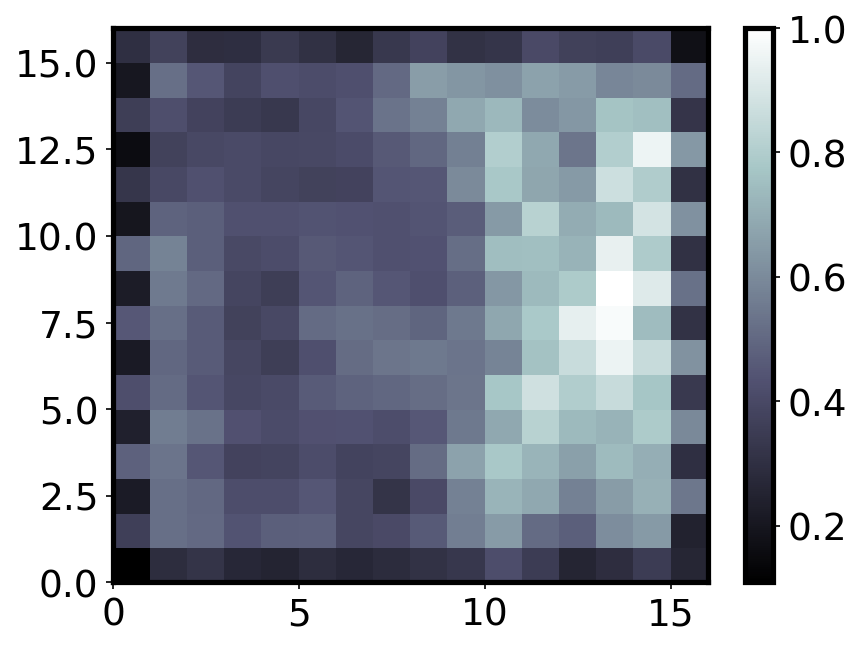

In [13]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T, cmap='bone')
colorbar()

## Feature plane

This is a map for each variable used, and it shows the magnitude of the weights associated to it for each neuron.

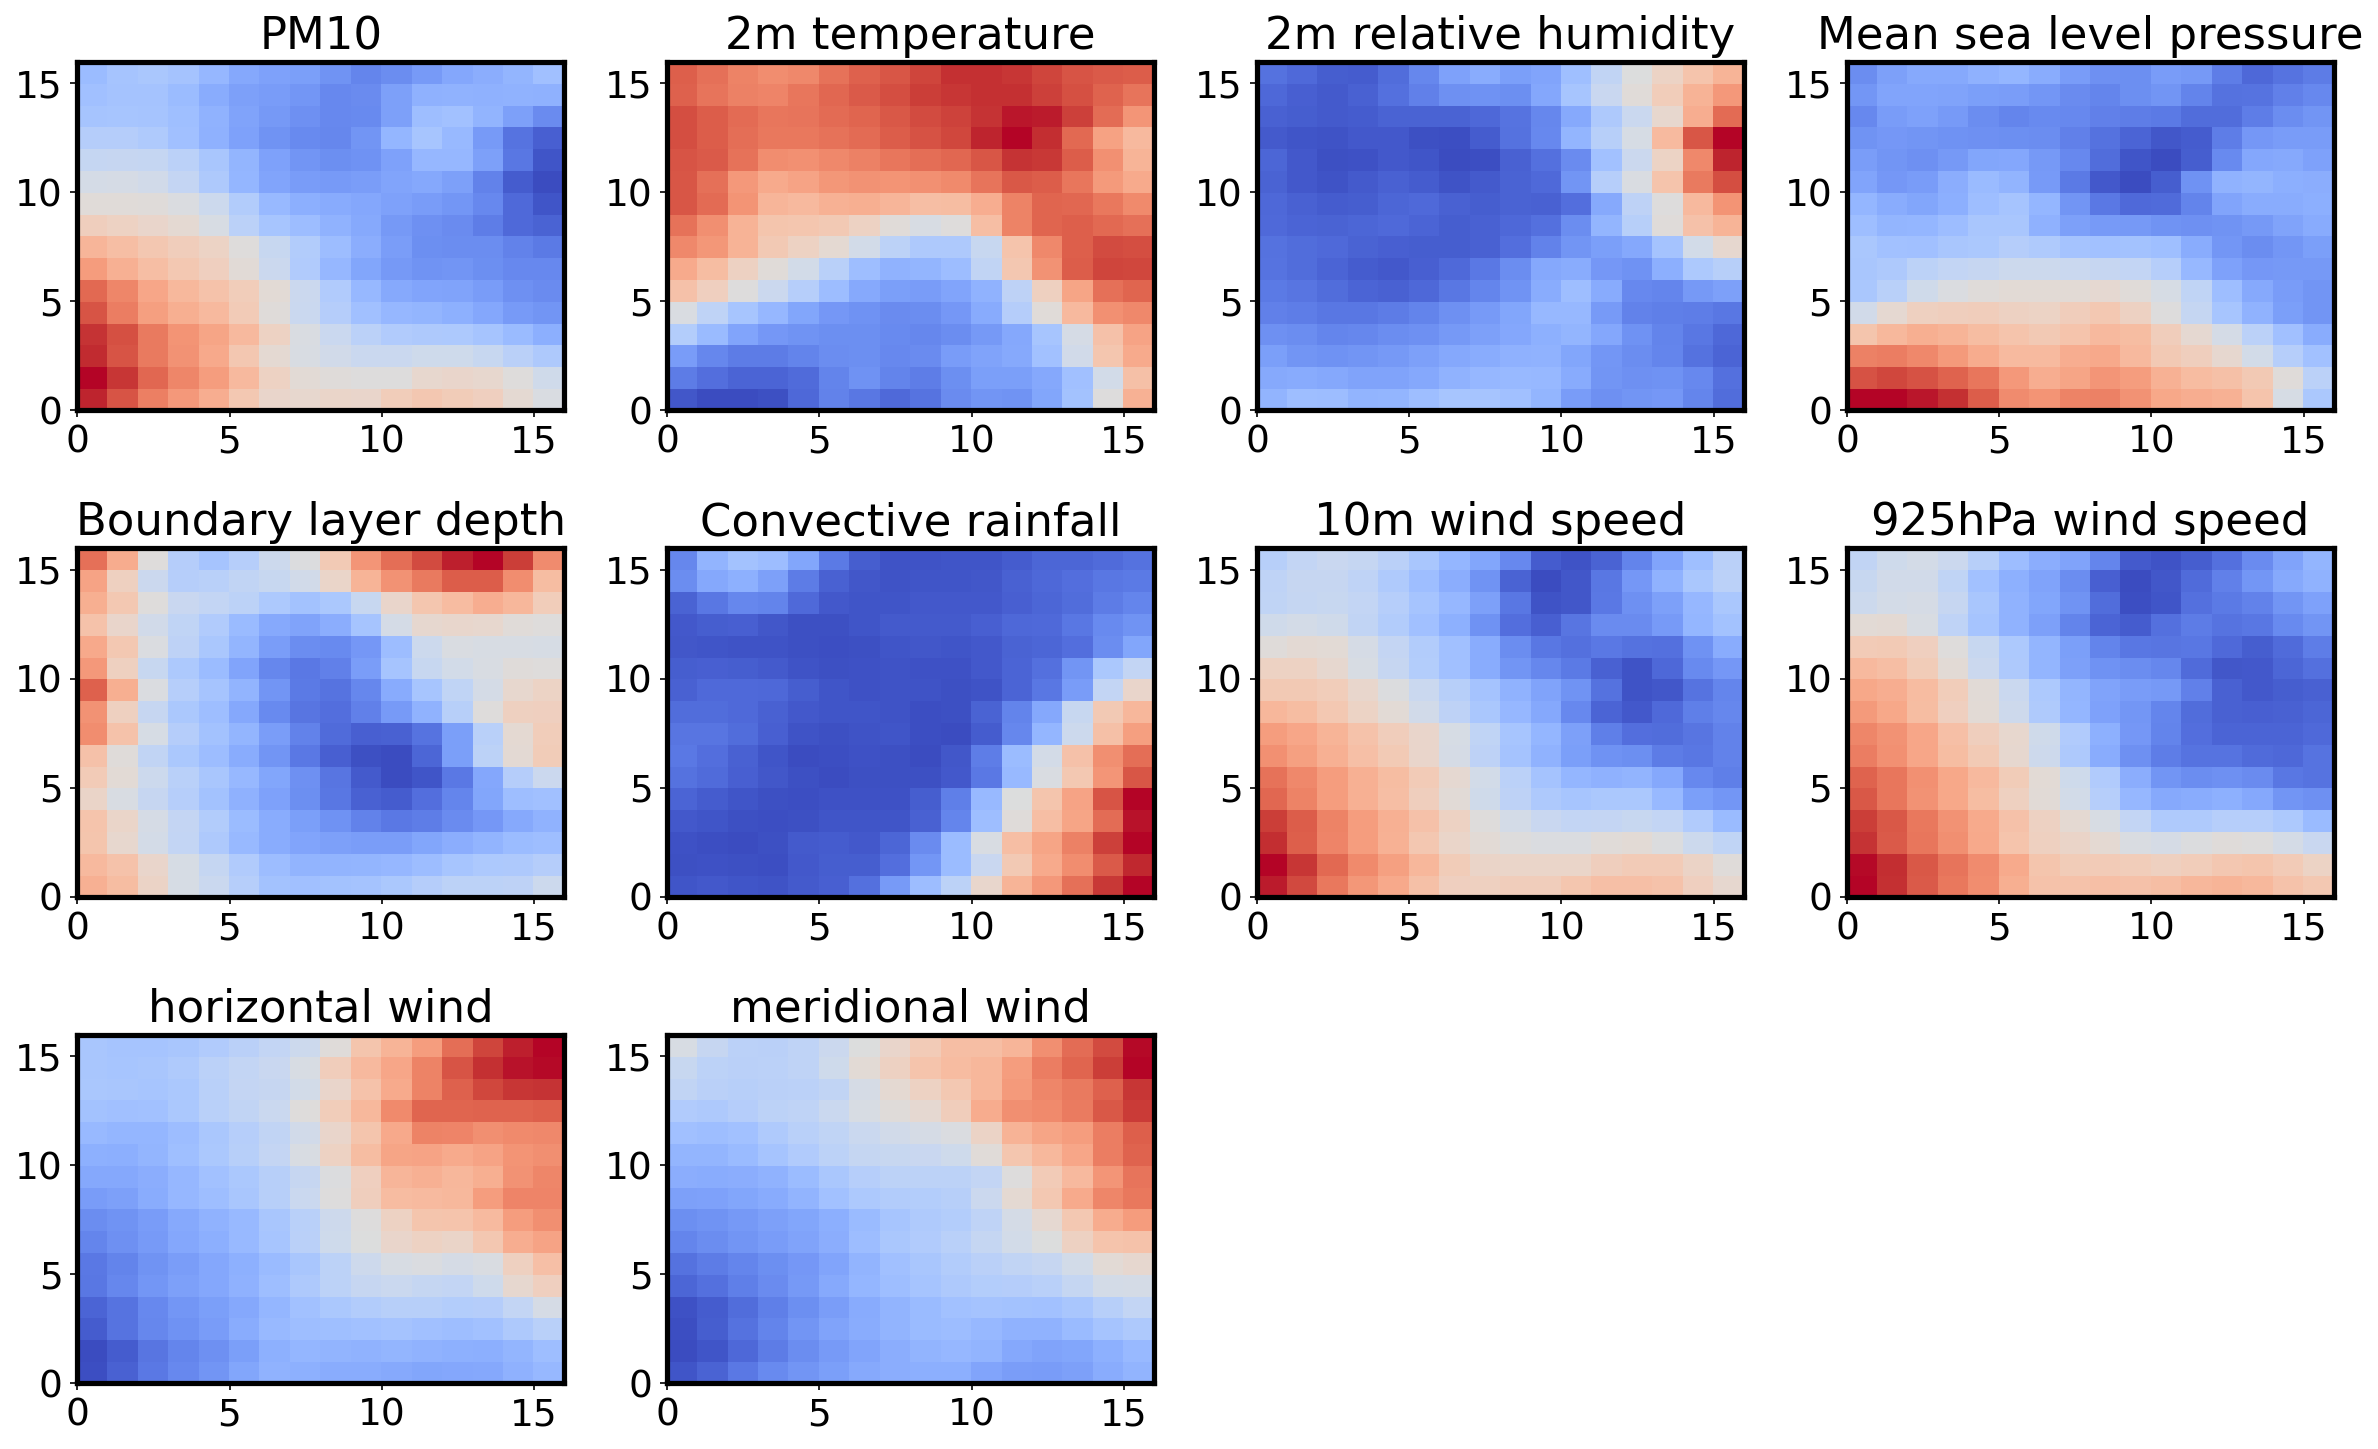

In [15]:
titles = ['PM10', '2m temperature', '2m relative humidity', 'Mean sea level pressure', 'Boundary layer depth', 
          'Convective rainfall', '10m wind speed', '925hPa wind speed', 'horizontal wind', 'meridional wind']
W = som.get_weights()
fig, ax = plt.subplots(3, 4, figsize=(16, 10))
ax = ax.flatten()
for i, f in enumerate(feature_names):
    #plt.subplot(5, 2, i+1)
    ax[i].set_title(titles[i])
    ax[i].pcolor(W[:,:,i].T, cmap='coolwarm')
    #ax[i].set_xticks(np.arange(num+1))
    #ax[i].set_yticks(np.arange(num+1))
ax[10].set_axis_off()
ax[11].set_axis_off()
plt.tight_layout()
plt.savefig('feature_patterns.png')

We see a pattern which establishes the relationship between each of the variables under consideration.
For example, nodes of higher PM10 concentration are associated with nodes of higher 10m wind speed and 925hPa wind speed and vice versa. The horizontal and meridional wind patterns suggest a prevailing northeasterly trade winds, which are known to be associated with dust emissions and transport. Regions of high PM10 concentration correspond to somewhat lower temperatures, which may be expected, but more diurnal scale analysis is need to verify this statement. The analysis also reveals that increased dust concentration may lower relative humidity at the surface, and this could potentially affect tropical cyclone development over the North Atlantic as been speculated in many papers.     

## Most relevant feature plane
By associating each neuron to the feature with the maximum weight, we divide the map into distinct regions, where specific features are most important (high values).

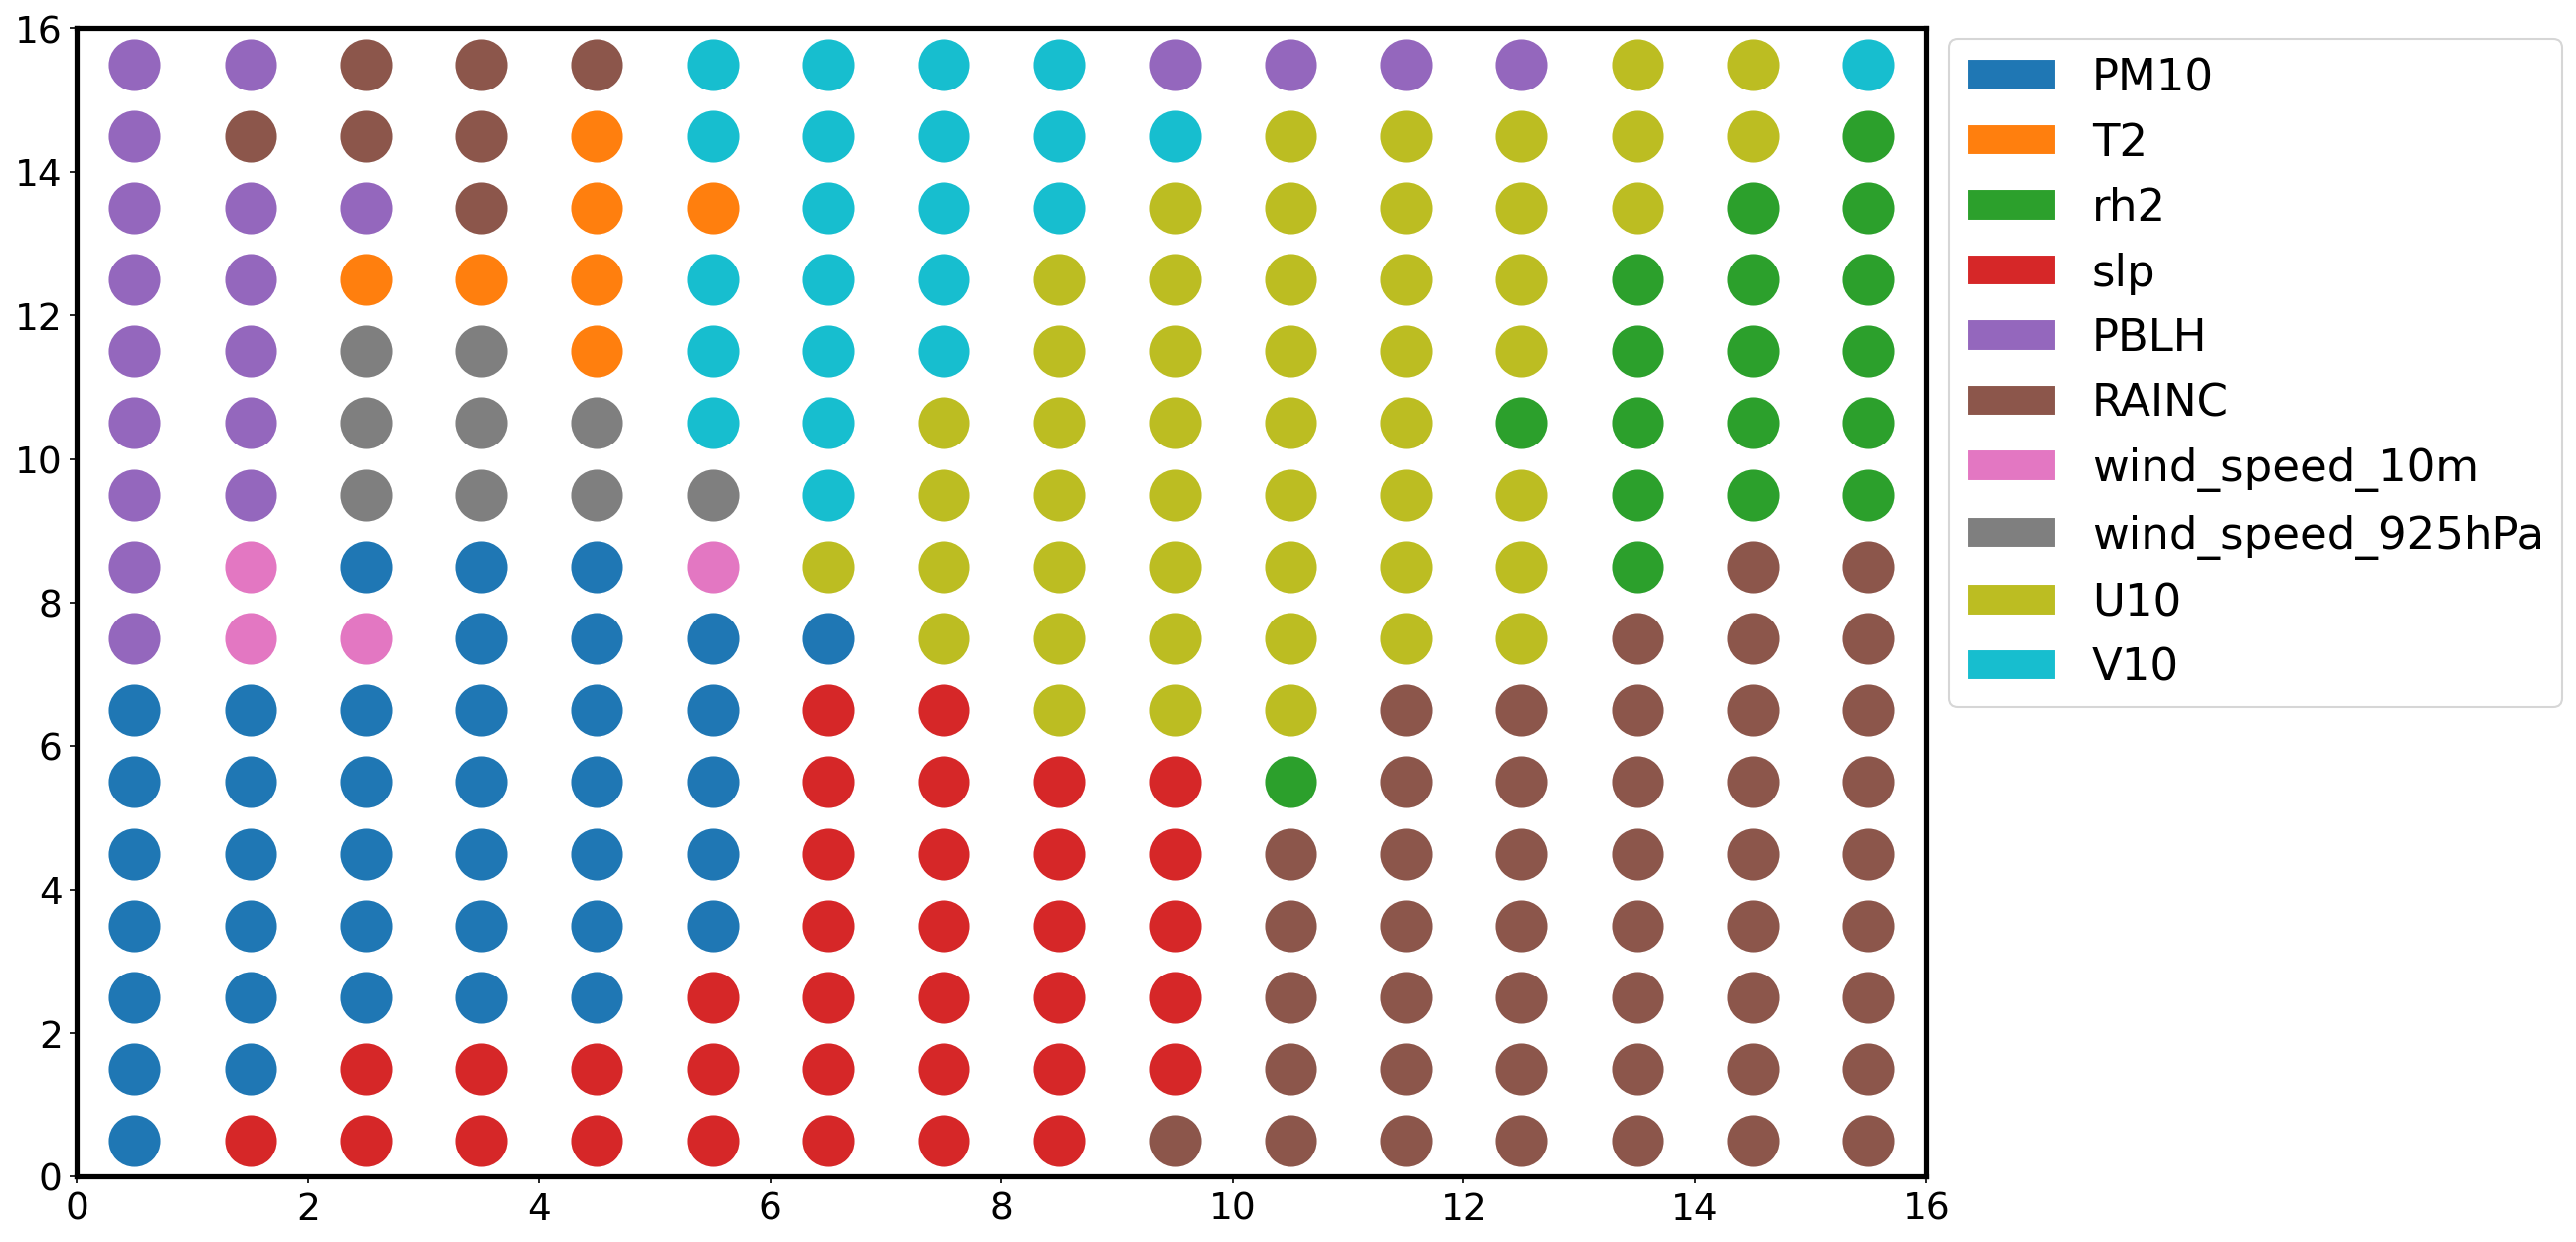

In [18]:
Z = np.zeros((num, num))
W = som.get_weights()
plt.figure(figsize=(16, 10))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([i+.5], [j+.5], color='C'+str(feature),
                 marker='o', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .7))     
plt.xlim([0, num])
plt.ylim([0, num])
plt.show()